In [1]:
import pandas as pd
import numpy as np
import uuid
import geopandas as gd
import matplotlib.pyplot as plt

## patient data - code by Gavin Chait, Viares academy 

In [5]:
df = pd.read_csv(r'path\patient-data-anonymisation-exercise.csv')
df[df["PATIENT_ID"] == "71ba0469-f0cc-4177-ac70-ea07cb01c8b8"]
# Specify columns for removal
suppression = ["SSN", "DRIVERS", "PASSPORT", "FIRST", "LAST", "MAIDEN", "ADDRESS", "ZIP"]
# And drop them
df.drop(suppression, axis=1, inplace=True)


sigma = 0.001 # standard deviation, i.e. the degree of variation from the original data we allow
mu = 1 # the original data, considered the `mean`

np.random.normal(mu, sigma)

1.0000807579973237

In [6]:
from collections import defaultdict

class Pseudonymise:
    
    def __init__(self, sigma=0.001):
        # Initialise a defaultdict, this creates a default dictionary item if it doesn't exist
        # We use this to ensure we maintain data integrity while still randomising
        # http://ikigomu.com/?p=28
        self.sigma = sigma
        self.mu = 0 # we want a deviation from the true point
        # Pseudo-patient dict
        self.pp = defaultdict(lambda: {"uuid":str(uuid.uuid4()),
                                       "lat": np.random.normal(self.mu, self.sigma),
                                       "lon": np.random.normal(self.mu, self.sigma)
                                      })
        
    def create_data(self, identities):
        """
        For each unique identity produce a unique UUID, and a Gaussian randomised `LAT` and `LON`.

        Paramaters
        ----------
        identities: list of strings

        Returns
        -------
        dict
            Each dict entry contains a record containing a "uuid" and modifier for "lat" and "lon"
        """
        for _id in identities:
            self.pp[_id]
        return self.pp
    
    def redact(self, row):
        """
        For a given row in a dataframe, return the pseudonymised version of "PATIENT_ID", "LAT", "LON".
        
        Parameters:
        row: DataFrame row
        
        Returns:
        DataFrame slice of row
        """
        return [
            self.pp[row["PATIENT_ID"]]["uuid"],
            row["LAT"] + self.pp[row["PATIENT_ID"]]["lat"],
            row["LON"] + self.pp[row["PATIENT_ID"]]["lon"],
        ]

p = Pseudonymise()
pp_data = p.create_data(df["PATIENT_ID"])
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html
fields = ["PATIENT_ID", "LAT", "LON"]
df[fields] = df[fields].apply(p.redact, axis=1, result_type="expand")

<AxesSubplot:>

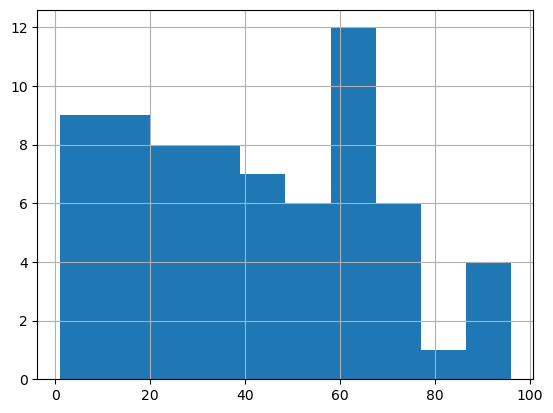

In [7]:
# Create a copy of the source data since aggregations are destructive
dfa = df.copy()
# Convert the date fields to pandas dates
for c in ["START", "STOP", "BIRTHDATE", "DEATHDATE"]:
    dfa[c] = dfa[c].apply(lambda x: pd.to_datetime(x, errors="coerce", dayfirst=True).date())
# Filter for the final medical treatment for all deceased patients
dfa = dfa[dfa.STOP==dfa.DEATHDATE]
dfa.sort_values(by="STOP", inplace=True)
dfa.drop_duplicates(subset="PATIENT_ID", keep="last", inplace=True)
# Create the DEATHAGE 
# This is a VERY approximate age at death calculation
dfa["DEATHAGE"] = dfa.DEATHDATE.apply(lambda x: x.year) - dfa.BIRTHDATE.apply(lambda x: x.year)
# And draw the DEATHAGE distribution, divided into n bins
dfa["DEATHAGE"].hist(bins=10)

## EXERCISE - homework

In [10]:
# create range column
dfa['DEATHAGE_range'] = ""

# deathage classes - 10 years 
conditions = [
    (dfa['DEATHAGE'] <= 10),
    (dfa['DEATHAGE'] > 10) & (dfa['DEATHAGE'] <= 20),
    (dfa['DEATHAGE'] > 20) & (dfa['DEATHAGE'] <= 30),
    (dfa['DEATHAGE'] > 30) & (dfa['DEATHAGE'] <= 40),
    (dfa['DEATHAGE'] > 40) & (dfa['DEATHAGE'] <= 50),
    (dfa['DEATHAGE'] > 50) & (dfa['DEATHAGE'] <= 60),
    (dfa['DEATHAGE'] > 60) & (dfa['DEATHAGE'] <= 70),
    (dfa['DEATHAGE'] > 70) & (dfa['DEATHAGE'] <= 80),
    (dfa['DEATHAGE'] > 80) & (dfa['DEATHAGE'] <= 90),
    (dfa['DEATHAGE'] > 90)
]
values = ['1-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-96']
dfa['DEATHAGE_range'] = np.select(conditions, values)
df_range = dfa.set_index('DEATHAGE_range')

# calculating statistics
df_count = dfa.groupby('DEATHAGE_range', as_index=False)['DESCRIPTION'].nunique().rename(columns={'DESCRIPTION': 'Unique_description'}).set_index('DEATHAGE_range')
df_mean = dfa.groupby('DEATHAGE_range', as_index=False)['TOTAL_CLAIM_COST'].mean().rename(columns={'TOTAL_CLAIM_COST': 'Mean_TOTAL_CLAIM_COST'}).set_index('DEATHAGE_range')
df_total = dfa.groupby('DEATHAGE_range', as_index=False)['TOTAL_CLAIM_COST'].sum().rename(columns={'TOTAL_CLAIM_COST': 'Sum_TOTAL_CLAIM_COST'}).set_index('DEATHAGE_range')

# list of dataframes
dfs = [df_count,df_mean,df_total,df_range]

df_final = dfs[0].join(dfs[1:])
df_final.sort_values(by=['DEATHAGE'])

,Unique_description,Mean_TOTAL_CLAIM_COST,Sum_TOTAL_CLAIM_COST,PATIENT_ID,START,STOP,ENCOUNTERCLASS,DESCRIPTION,TOTAL_CLAIM_COST,PAYER_COVERAGE,...,RACE,ETHNICITY,GENDER,BIRTHPLACE,CITY,STATE,COUNTY,LAT,LON,DEATHAGE
DEATHAGE_range,,,,,,,,,,,,,,,,,,,,,
1-10,2,129.16,1162.44,ed4f0aea-81ab-4954-adfa-88b4fbc33dda,2019-05-15,2019-05-15,wellness,Death Certification,129.16,0.00,...,white,nonhispanic,F,Sturbridge Massachusetts US,Salem,Massachusetts,Essex County,42.517699,-70.908071,1
1-10,2,129.16,1162.44,f6528edb-3d38-46af-aa72-e5ca53d73e64,2005-08-19,2005-08-19,wellness,Death Certification,129.16,0.00,...,white,nonhispanic,M,Milford Massachusetts US,Quincy,Massachusetts,Norfolk County,42.242644,-71.058432,1
1-10,2,129.16,1162.44,10d941d5-535f-4da8-9f28-6047f7711b6a,1976-11-11,1976-11-11,wellness,Death Certification,129.16,0.00,...,white,nonhispanic,F,Harwich Massachusetts US,Leicester,Massachusetts,Worcester County,42.205306,-71.874089,1
1-10,2,129.16,1162.44,35986f82-8c58-4719-aaa1-f08641f8b722,1983-11-07,1983-11-07,wellness,Death Certification,129.16,0.00,...,white,hispanic,F,Lima Lima Province PE,Waltham,Massachusetts,Middlesex County,42.322167,-71.190767,1
1-10,2,129.16,1162.44,f3fe03bd-0ab6-4f1a-89c9-c5d694da8b06,2010-01-10,2010-01-10,wellness,Death Certification,129.16,0.00,...,white,nonhispanic,M,Boston Massachusetts US,Lynn,Massachusetts,Essex County,42.432297,-70.974408,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71-80,3,129.16,645.80,546526fe-4e04-4b1b-84d4-5259f4165b21,1991-06-02,1991-06-02,emergency,Stroke,129.16,89.16,...,white,nonhispanic,M,Maynard Massachusetts US,Worcester,Massachusetts,Worcester County,42.240024,-71.819908,77
81-90,1,129.16,129.16,145cc6f7-2baa-43b0-af51-9299633307e6,2013-03-12,2013-03-12,emergency,Stroke,129.16,89.16,...,white,nonhispanic,F,Boston Massachusetts US,West Springfield,Massachusetts,Hampden County,42.151099,-72.662842,90
91-96,3,129.16,387.48,ab948124-a4c1-4907-8c94-065e7324cf5b,2013-08-20,2013-08-20,emergency,Stroke,129.16,89.16,...,asian,hispanic,F,Lima Lima Province PE,Cambridge,Massachusetts,Middlesex County,42.419682,-71.128273,91
